## Imports/Setup

In [2]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Land/Sea Network Mask

#### Land Sea Mask

In [9]:
#need to load some datasets for filtering ocean vs land. Add all base data here and in 02 processing, filter out artic and others
#for reference, prior version (unknown source): ('/local/data/artemis/observations/masks/originals/lsmask.nc') 

#NCEP land-sea mask (https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html)
land_mask_direct_url = 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/land.nc'
land_mask_destination_folder = download_folder_root+r'Masks/originals/'
land_mask_destination_filename = 'mask_NOAA_land-sea_20220916.nc'
download(land_mask_direct_url, land_mask_destination_folder, land_mask_destination_filename) 
#here 1 means land and 0 is ocean. We flip in the 02 processing code

Saving https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/land.nc to /data/artemis/workspace/ds4114/online_data/Masks/originals/mask_NOAA_land-sea_20220916.nc...
Complete


#### Topography / Bathymetry

I am not sure where to obtain the data used before to reproduce results - one potential version below from online but it is too large and regridding creates issues. 

In [3]:
#Previous set
xr_open_dataset_custom('/local/data/artemis/observations/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc') #topography

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    Height   (lat, lon) float64 ...

## Processing: Land/Sea Network Mask

#### Both Network Mask and Bathymetry

This is slightly different than the original code because 1) we use updated, original data sources (which have values between 0-1, not binary) and we dont use the sobel filter (causes more blur)

In [14]:
#assumed we have downloaded directly and have 2 files
ds_topo = xr_open_dataset_custom('/local/data/artemis/observations/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc') #topography
        #This is the prior file that I am not able to directly download or process from online
ds_lsmask_raw = xr.open_dataset('/data/artemis/workspace/ds4114/online_data/Masks/originals/mask_NOAA_land-sea_20220916.nc', decode_times=False) #land mask
ds_lsmask_raw = ds_lsmask_raw.drop_vars('time_bnds')

In [15]:
ls_regridder = xesmf.Regridder(ds_lsmask_raw, ideal_grid_back_in_time, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
ds_lsmask = ls_regridder(ds_lsmask_raw, keep_attrs=True)
ds_lsmask = ds_lsmask.rename({'latitude': 'lat','longitude': 'lon'}) 
ds_lsmask = ds_lsmask.rename({'land':'mask'}) #rename this way to be consistent with prior work
#ds_lsmask

In [16]:
ds_topo = ds_topo.roll(lon=180, roll_coords='lon')
ds_topo['lon'] = np.arange(0.5, 360, 1)

ds_lsmask = ds_lsmask.roll(lon=180, roll_coords='lon') #added to reuse same code with lat/lon values
ds_lsmask['lon'] = np.arange(0.5, 360, 1)

ds_lsmask = ds_lsmask.sortby('lat').squeeze().drop('time')
data = ds_lsmask['mask'].where(ds_lsmask['mask']<1)  #UPDATE: modified because >0 is land/coast in raw data but we want 1=ocean
### Define Latitude and Longitude
lon = ds_lsmask['lon']
lat = ds_lsmask['lat']

In [17]:
### Remove coastal points
#coast = (sobel(ds_lsmask['mask'])>0)  #defined by sobel edge detection - this really blurs the data; the original defined coast as between 0 and 1 so I think we can just use that instead?
coast = (ds_lsmask['mask']>0)
data = data.where(coast==0)

### Remove shallow sea, less than 100m
### This picks out the Solomon islands and Somoa
data = data.where(ds_topo['Height']<-100)

### remove arctic
data = data.where(~((lat>79)))
data = data.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
data = data.where(~((lat>67) & (lat<80) & (lon>-180+360) & (lon<-100+360)))

### remove caspian sea, black sea, mediterranean sea, and baltic sea
data = data.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))

### remove hudson bay
data = data.where(~((lat>50) & (lat<70) & (lon>-100+360) & (lon<-70+360)))
data = data.where(~((lat>70) & (lat<80) & (lon>-130+360) & (lon<-80+360)))

### Remove Red sea
data = data.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
data = data.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))

In [18]:
# Roll to longitude in SOCAT data #
data = data.roll(lon=180, roll_coords='lon')
#lon = np.arange(-179.5, 180, 1) #UPDATE: There was a bug on this line(?); should be like line below 
data['lon'] = np.arange(-179.5, 180, 1)

In [19]:
data = data.where(data != 0, 1) #UPDATE: newly added; flip data so 1 is ocean (0->1); land/coast can stay null

In [24]:
#regrid to -180 to 180 long and make a dataset
netmask = xr.Dataset({'net_mask':(['ylat','xlon'],data.data)
                    },coords={'ylat':(['ylat'],data.lat.values),'xlon':(['xlon'],xlon.values)})
netmask.net_mask.attrs['desc'] = "1 means ocean; null is land"
netmask

<xarray.Dataset>
Dimensions:   (ylat: 180, xlon: 360)
Coordinates:
  * ylat      (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon      (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    net_mask  (ylat, xlon) float32 nan nan nan nan nan ... nan nan nan nan nan

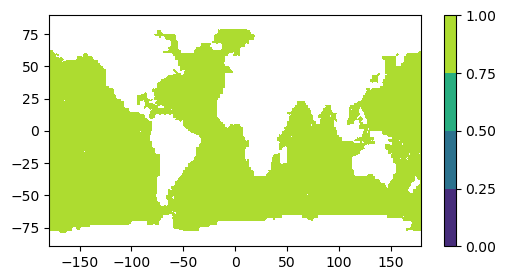

In [25]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(netmask.xlon,netmask.ylat,netmask.net_mask, levels = np.linspace(-0, 1, 5) ) 
plt.colorbar()

In [44]:
#output
output_xarray_with_date(netmask, '/data/artemis/workspace/ds4114/online_data/Masks/processed/', 'mask_LEAP_land-sea-network', with_date=False, filetype=output_file_type, overwrite=False)

Saved mask_LEAP_land-sea-network.nc to /data/artemis/workspace/ds4114/online_data/Masks/processed/
